# Main

In [10]:
##########################################################################
import os

# Generic
import pandas as pd
import numpy as np
import scipy
from itertools import islice, cycle
import math
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache
import scipy.integrate

# cosmology
import pyccl as ccl
from astropy.io import fits
import yaml
import sacc
import time

# covariance - Charlie's version of TJPCov
MODULE_PATH = "/home/c2042999/TJPCov/tjpcov/__init__.py"
MODULE_NAME = "tjpcov"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from tjpcov.covariance_calculator import CovarianceCalculator

# Generate data sets
from sklearn.datasets import make_blobs
import sklearn
#print(sklearn.__version__) # should be 1.3.2

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
import matplotlib
#import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from chainconsumer import ChainConsumer, Chain, make_sample
from IPython.display import display, Math
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# MGCAMB
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

# f(R) emu (eMANTIS)
from emantis import FofrBoost

# Initialise and emulator instance.
emu_fR = FofrBoost()

In [2]:
from Likelihood_PCADR import *

Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
##########################################################################
#### Train the emulators ####
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 500)
forecast_years = ["1", "10"]  # Assuming integers are appropriate

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


bins = {
    "sources": {},
    "lenses": {}
}

# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=True,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=True,
                                                           save_file=False)


#(5, 256)
Binned_distribution_lens = [list(bins["lenses"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_lens = np.append(Binned_distribution_lens,\
               [list(bins["lenses"]["1"].items())[i+1][1]], axis=0)

Binned_distribution_source = [list(bins["sources"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution_source = np.append(Binned_distribution_source,\
               [list(bins["sources"]["1"].items())[i+1][1]], axis=0)

cosmo_test = ccl.Cosmology(Omega_c = 0.27, 
                          Omega_b = 0.046, 
                          h = 0.7, 
                          n_s = 0.974,
                          A_s = 2.01e-9)

Bias_distribution_fiducial = np.array([1.562362*np.ones(len(redshift_range)),
                             1.732963*np.ones(len(redshift_range)),
                             1.913252*np.ones(len(redshift_range)),
                             2.100644*np.ones(len(redshift_range)),
                             2.293210*np.ones(len(redshift_range))])

binned_ell_test = bin_ell_kk(20, 1478.5, 13, Binned_distribution_source)

mockdata_test = Cell(binned_ell_test, \
                cosmo_test, redshift_range , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_test, [0.2,1e-5,1,0,0], linear=False, gravity_model="f(R)"),tracer1_type="k", tracer2_type="k")

mockdata_test = Cell(binned_ell_test, \
                cosmo_test, redshift_range , Binned_distribution_source,Binned_distribution_lens,Bias_distribution_fiducial,[0.2,1e-5,1,0,0],\
                Get_Pk2D_obj(cosmo_test, [0.2,1e-5,1,0,0], linear=False, gravity_model="nDGP"),tracer1_type="k", tracer2_type="k")


Training the emulator at aexp=0.3333... done.
Training the emulator at aexp=0.3650... done.
Training the emulator at aexp=0.4000... done.
Training the emulator at aexp=0.4167... done.
Training the emulator at aexp=0.4444... done.
Training the emulator at aexp=0.4762... done.
Training the emulator at aexp=0.5000... done.
Training the emulator at aexp=0.5263... done.
Training the emulator at aexp=0.5556... done.
Training the emulator at aexp=0.5882... done.
Training the emulator at aexp=0.6250... done.
Training the emulator at aexp=0.6667... done.
Training the emulator at aexp=0.7042... done.
Training the emulator at aexp=0.7692... done.
Training the emulator at aexp=0.8000... done.
Training the emulator at aexp=0.8696... done.
Training the emulator at aexp=0.9091... done.
Training the emulator at aexp=0.9524... done.
Training the emulator at aexp=1.0000... done.


In [4]:
# Define cosmology
cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)

cosmo_universe_linear = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9,
                          matter_power_spectrum='linear')

fR_universe = 3e-5
H0rc_universe = 0.0
MGParam_universe = [H0rc_universe,fR_universe,1,0,0]


value1 = [cosmo_universe["Omega_c"], 0.0, 0.0,cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0]]


# Create the output directory
mcmc_dir = "/home/c2042999/PCA_project/Likelihood_estimation_3x2pt_fsigma8/mcmc"

In [5]:
#### Define log likelihood #####
def log_likelihood(theta, Data, L_ch_inv,Data_fsigma8):
    Omega_c, mu0,Sigma0, A_s1e9, h, n_s, wb, b1, b2, b3, b4, b5 = theta

    Bias_distribution = np.array([b1*np.ones(len(z)),
                             b2*np.ones(len(z)),
                             b3*np.ones(len(z)),
                             b4*np.ones(len(z)),
                             b5*np.ones(len(z))])
    A_s = A_s1e9*1e-9
    MGparams = [0.2,1e-4,1.0,mu0,Sigma0]

    cosmo = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = wb/h**2,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    
    cosmo_linear = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = wb/h**2,
                      h = h,
                      n_s = n_s,
                      A_s = A_s,
                      matter_power_spectrum='linear')

    return loglikelihood(Data, cosmo,cosmo_linear, MGparams, L_ch_inv,Bias_distribution,Data_fsigma8)

#### Get Planck priors #####
sampler_Planck_arr = np.load("/home/c2042999/PCA_project/Prior_Planck_arr.npy")
mu_prior = [cosmo_universe['n_s'], cosmo_universe["Omega_b"]*cosmo_universe["h"]**2]
cov_prior = np.cov(sampler_Planck_arr.T)

#### Define log prior #####
def log_prior(theta):
    Omega_c, mu0,Sigma0, A_s1e9, h, n_s, wb, b1, b2, b3, b4, b5 = theta 

    #flat priors
    if not (0.28 < Omega_c + wb/h**2 < 0.36 and 0.0 < mu0 < 1.0 and -0.7 < Sigma0 < 0.7 \
            and 1.7 < A_s1e9 < 2.5 and 0.92 < n_s < 1 and 0.61 < h < 0.73 and 0.04 < wb/h**2 < 0.06 \
           and 0.8 < b1 < 3.0 and 0.8 < b2 < 3.0 and 0.8 < b3 < 3.0 and 0.8 < b4 < 3.0 and 0.8 < b5 < 3.0):
        return -np.inf
        
    gauss_funct = scipy.stats.multivariate_normal(mu_prior, cov_prior)
    
    return gauss_funct.logpdf([n_s, wb])

In [6]:
##### Load and collect the data for likelihood ###

## Reload if needed
#command = 'python Get_Data_3x2pt_fsigma8_MG.py --OmgC {} --OmgB {} --h {} --ns {} --As {} --gravity_flag "f(R)" --MG_param {}'.format(cosmo_universe["Omega_c"],cosmo_universe["Omega_b"],cosmo_universe["h"], cosmo_universe["n_s"],cosmo_universe["A_s"],fR_universe)
#os.system(command)
## Collect the data
npzfile = np.load("Data_storage.npz")

C_ell_data_mock = [npzfile['C_ell_data'],npzfile['ell_data'],npzfile['z'],npzfile['Binned_distribution_source'],\
                    npzfile['Binned_distribution_lens'],20,1478.5,13]
Data_fsigma8= [npzfile['z_eff_fsigma8'], npzfile['fsigma8_data'],np.matrix(npzfile['invcov_fsigma8'])]
L_choleski_inv = np.matrix(npzfile['L_ch_inv'])

gauss_invcov_rotated = np.matrix(npzfile['Inverse_cov'])

z = npzfile['z']
Bias_distribution_fiducial = np.array([1.229*np.ones(len(z)),
                            1.362*np.ones(len(z)),
                            1.502*np.ones(len(z)),
                            1.648*np.ones(len(z)),
                            1.799*np.ones(len(z))])

/tmp/ipykernel_2749809/1247777071.py:11: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  Data_fsigma8= [npzfile['z_eff_fsigma8'], npzfile['fsigma8_data'],np.matrix(npzfile['invcov_fsigma8'])]
/tmp/ipykernel_2749809/1247777071.py:12: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  L_choleski_inv = np.matrix(npzfile['L_ch_inv'])
/tmp/ipykernel_2749809/1247777071.py:14: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regu

## Tests

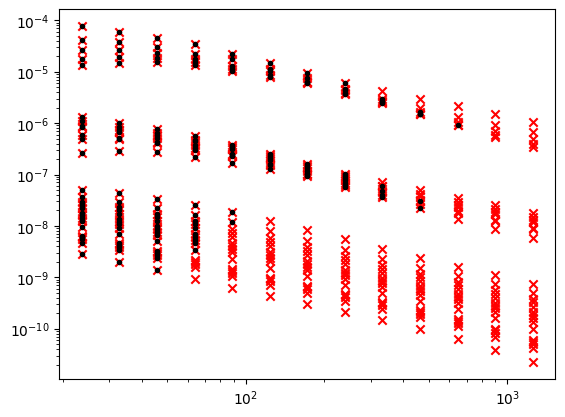

In [7]:
plt.scatter(npzfile['ell_data'],npzfile['C_ell_data'], color="r", marker='x')

for i in range(351):
    if L_choleski_inv[0,i] !=0:
        plt.scatter(npzfile['ell_data'][i],npzfile['C_ell_data'][i], color="k", marker='.')

plt.xscale("log")
plt.yscale("log")

(351, 351)


/home/c2042999/PCA_project/Likelihood_estimation_3x2pt_fsigma8/Likelihood_PCADR.py:1476: RuntimeWarning: invalid value encountered in divide
  return cov/np.outer(sig, sig)


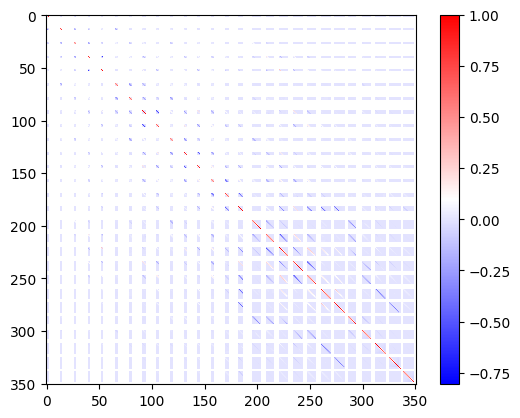

In [8]:
print(gauss_invcov_rotated.shape)
plt.imshow(cov2corr(gauss_invcov_rotated), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()

In [11]:
"""Compare with v4 plot"""
#cut_1 = gauss_invcov_rotated[~np.all(gauss_invcov_rotated == 0, axis=1)]
#plt.imshow(cov2corr(cut_1[:,~np.all(cut_1 == 0, axis=0)]), origin='upper',  cmap='bwr')

#plt.colorbar()
#plt.show()

'Compare with v4 plot'

# Main

In [7]:
## add C_ell_data_mock, L_choleski_inv, Data_fsigma8
#### Define log probability #####
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, C_ell_data_mock, L_choleski_inv,Data_fsigma8)

In [12]:
# Set the random seed for reproducibility
np.random.seed(10)

# Initialize the walkers
Omega_c_est = 0.27
h_est = 0.7
A_s1e9_est = 2.1
n_s_est = 0.96
mu0_est = 0.1
Sigma0_est = 0.05
wb_est = 0.0223
b1_est = Bias_distribution_fiducial[0][0]
b2_est = Bias_distribution_fiducial[1][0]
b3_est = Bias_distribution_fiducial[2][0]
b4_est = Bias_distribution_fiducial[3][0]
b5_est = Bias_distribution_fiducial[4][0]

n_steps = 5
nwalkers = cpu_count()
print(nwalkers)
# Initialize the walkers
pos = [Omega_c_est, mu0_est,Sigma0_est, A_s1e9_est, h_est, n_s_est, wb_est,b1_est,b2_est,b3_est,b4_est,b5_est] \
+ np.append(np.append(1e-3 * np.random.randn(nwalkers, 5), 1e-5*np.random.randn(nwalkers, 2), axis = 1), \
            1e-3 * np.random.randn(nwalkers, 5), axis = 1)

nwalkers, ndim = pos.shape

sampler_PCA = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
start = time.time()
sampler_PCA.run_mcmc(pos, n_steps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

80


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/emcee/ensemble.py:492: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_prob = np.array([float(l[0]) for l in results])
  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/emcee/ensemble.py:492: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_prob = np.array([float(l[0]) for l in results])
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/emcee/ensemble.py:492: 

Serial took 1361.2 seconds


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/emcee/utils.py:23: DeprecationWarning: 'chain' is deprecated. Use 'get_chain()' instead.
  deprecation_warning(msg)


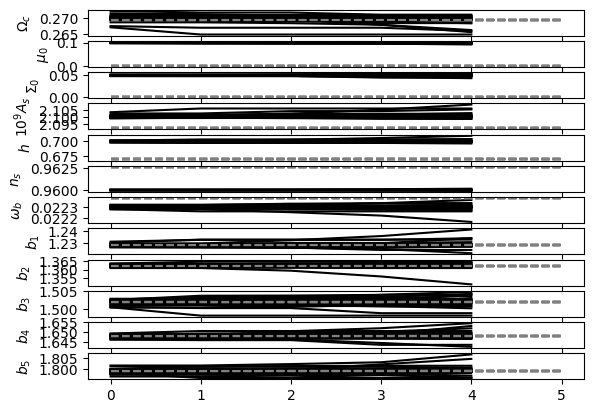

In [10]:
sampler_PCA_arr = sampler_PCA.chain

fig, ax = plt.subplots(len(sampler_PCA_arr[0, 0, :]), sharex=True)
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0,cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0][0], Bias_distribution_fiducial[1][0],\
         Bias_distribution_fiducial[2][0],Bias_distribution_fiducial[3][0],\
         Bias_distribution_fiducial[4][0]]

for i in range(len(sampler_PCA_arr)):
    for j in range(len(sampler_PCA_arr[0, 0, :])):
        ax[j].plot(sampler_PCA_arr[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_PCA_arr[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        